In [110]:
from caiman_online import analysis, plot, utils, statistics, plot, vis
from glob import glob
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import matplotlib as mpl
import scipy
import warnings
import sklearn

%load_ext autoreload
%autoreload 2

sns.set_style('ticks',{'axes.spines.right': False, 'axes.spines.top': False}) # removes annoying top and right axis
sns.set_context('notebook') # can change to paper, poster, talk, notebook
pd.set_option('display.max_columns',10) # limits printing of dataframes

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['savefig.dpi'] = 300 # default resolution for saving images in matplotlib
mpl.rcParams['savefig.format'] = 'png' # defaults to png for saved images (SVG is best, however)
mpl.rcParams['savefig.bbox'] = 'tight' # so saved graphics don't get chopped
mpl.rcParams['figure.constrained_layout.use'] = True # so I don't have to keep saying contrainsted_layout = True in all subplots
mpl.rcParams['image.cmap'] = 'viridis'

%config InlineBackend.figure_format = 'retina' # doesn't work in vscode

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
warnings.filterwarnings('ignore', category=RuntimeWarning, module='scipy', lineno=2500)

In [3]:
os.chdir('E:/caiman_scratch/lab_meeting')
os.getcwd()

'E:\\caiman_scratch\\lab_meeting'

In [86]:
# load up the exported visStim conds
mat = scipy.io.loadmat('daqdata.mat', squeeze_me=True)['out']
powers = mat['powers'].item()
visID = mat['visID'].item()
outID = mat['outID'].item()
hr = mat['hr'].item()
vpsths = mat['PSTHs'].item()

In [5]:
oris = np.arange(-45,360,45) # oris used
vis_oris = np.array(list(map(lambda x: oris[x], visID-1))) # convert visIDs to orientations (trialwise)
vis_oris

array([270,   0, 315,  45,  45,   0, 225, 315,  90,  90, 270, 180,  90,
        45,   0, -45, 225,  45, 225, 315,  90, 270,  90, 315,  45, 225,
       225, 180, 315,  45, 225,   0,   0,   0, 315, 180,  45, 180, 180,
       180,  90, 270,  45, 225,  90, 135, 225, 270,   0,   0,  45, 270,
       225,   0, 315, 135, -45, 180,  45,   0, -45, 180, 135, 270, 270,
       270, 225,   0, 225,  45,  45,  45, 225, 180, -45, 270,  90, 225,
        45, -45, 180, 180,  90,  45,  45,  45, 270,   0,  90,   0,  90,
       225,  90,  90, 315, -45, 135,  45,  90, 315, 270, 225, 225, 315,
       135, -45, 135, 270,  45, -45, 135,  45, -45, 180, -45,  90,   0,
       135, 225, -45, 270,  90, 180, -45,   0, 225, 225,  90, 135,  45,
        45, 180, -45, 315, -45,  90, 225, 180, 225,  45, 135, 225,  45,
       225, 315,  90, 225,  45,  90,   0, 135,  90, -45, 180, 135, 315,
       135])

In [76]:
nplanes = 3
traces = []
for plane in range(nplanes):
    js_this_plane = glob(f'./ori_tiffs/out/*plane{plane}*.json')
    traces.append(analysis.concat_chunked_data(js_this_plane, normalizer='scale'))

traces = np.concatenate(traces, axis=1)

In [69]:
traces.shape
# there are actually 157 tifs but this is expected since caiman quit before the acq

(124, 298, 31)

In [246]:
# real time, not frames
length_seconds = int(traces.shape[2]/6.36)
times = np.round(np.linspace(0,length_seconds, 6),1)

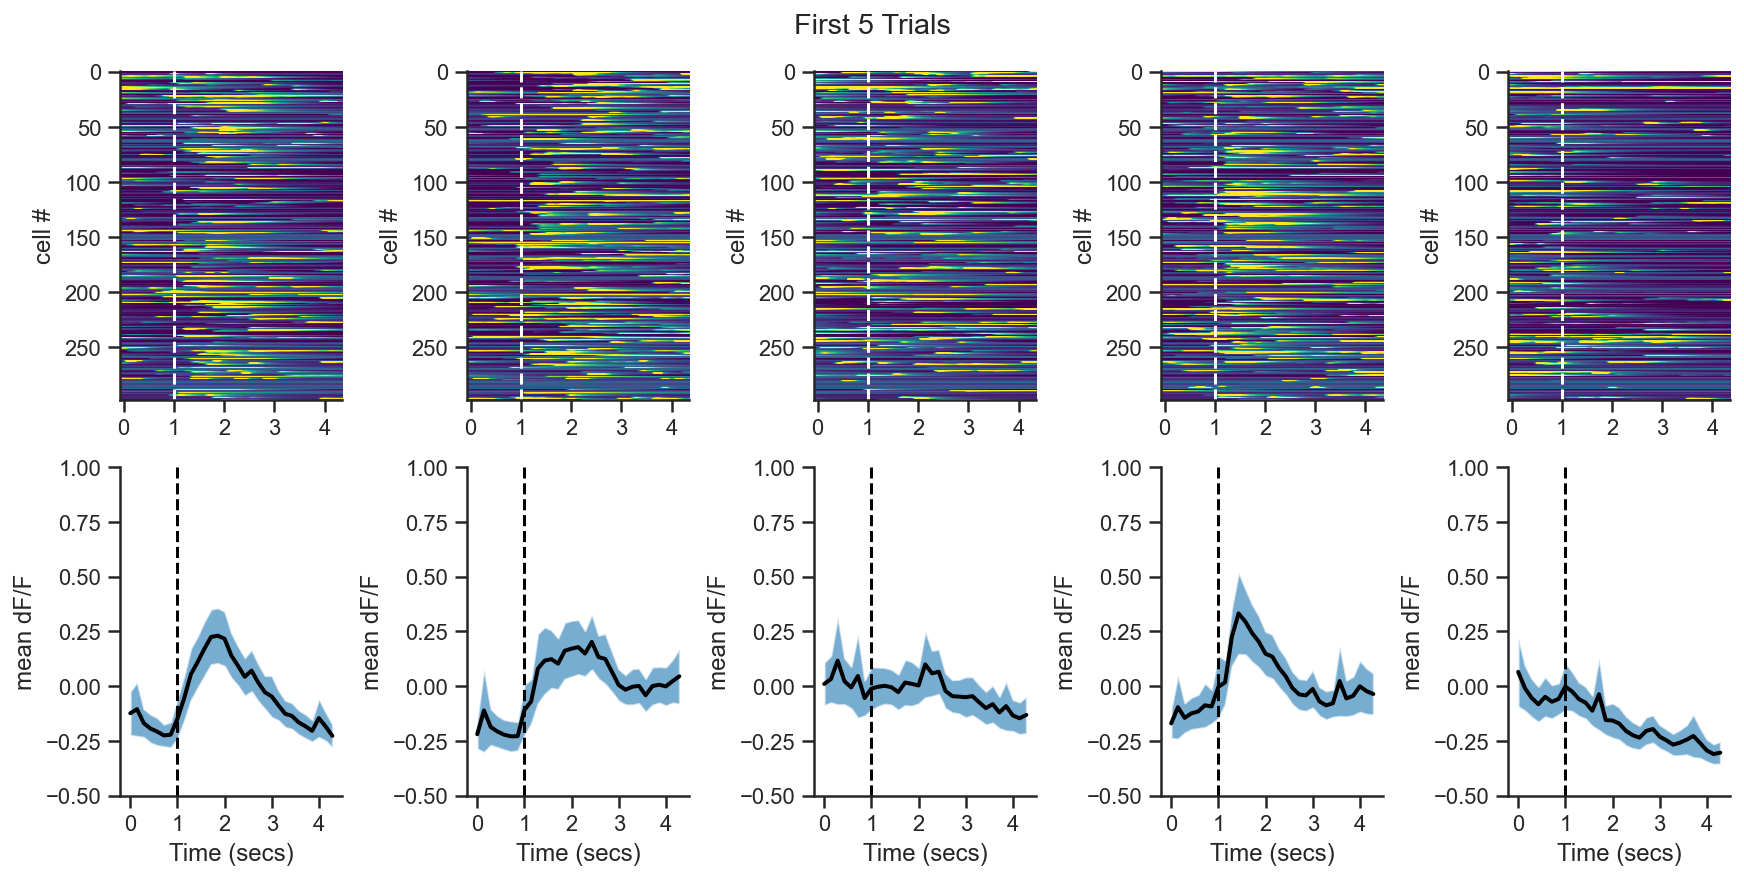

In [258]:
ncol=5
f, axes = plt.subplots(2,ncol, figsize=(12,6))
axes = axes.ravel()

for i,ax in enumerate(axes[0:5]):
    ax.set_ylabel('cell #')
    ax.imshow(traces[i+5,:,:], aspect='auto', vmin=-.5, vmax=1)
    ax.set_xticks(np.arange(0,5)*7)
    ax.set_xticklabels(np.arange(0,5))
    ax.axvline(7, ls='--', color='white')
    #f.colorbar()

for i,ax in enumerate(axes[5:11]):
#     ax.plot(np.mean(traces[i,:,:],axis =0))
    plot.mean_traces_ci(traces[i+5,:,:], ax=ax)
    ax.set_ylim(-0.5,1)
    ax.set_ylabel('mean dF/F')
    ax.set_xlabel('Time (secs)')
    ax.set_xticks(np.arange(0,5)*7)
    ax.set_xticklabels(np.arange(0,5))
    ax.axvline(7, ls='--', color='k')
    
plt.suptitle('First 5 Trials')

plt.savefig('first 5 trials caiman')

In [356]:
win = (0, 0.8, 1.4, 2.2)

df = vis.create_df(traces, vis_oris, 'ori', fr=6.36)
df, mdf = vis.run_pipeline(df, win, 'ori')

C:\Users\Will\Anaconda3\envs\caiman-online\lib\site-packages\scipy\stats\stats.py:3641: F_onewayConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(F_onewayConstantInputWarning())


There are 51 visually responsive cells, out of 298 (17.11%)


c:\users\will\lab code\caiman_online\caiman_online\vis.py:219: RuntimeWarning: invalid value encountered in true_divide
  def _vis_resp_anova(data):


c:\users\will\lab code\caiman_online\caiman_online\plot.py:87: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(data.ori180.unique())
c:\users\will\lab code\caiman_online\caiman_online\plot.py:94: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(data.ori.unique())


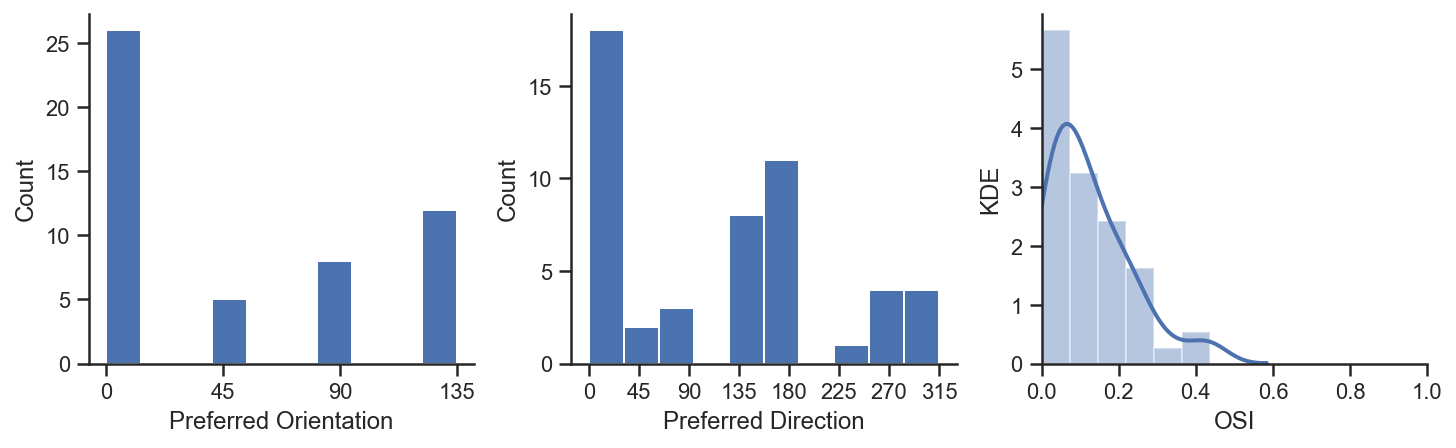

In [359]:
mdf = mdf[mdf.vis_resp==True]

plot.plot_ori_dists(mdf)

plt.gcf().savefig('ori dists 51 cells of 298 aka 17 percent')

C:\Users\Will\Anaconda3\envs\caiman-online\lib\site-packages\seaborn\axisgrid.py:382: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


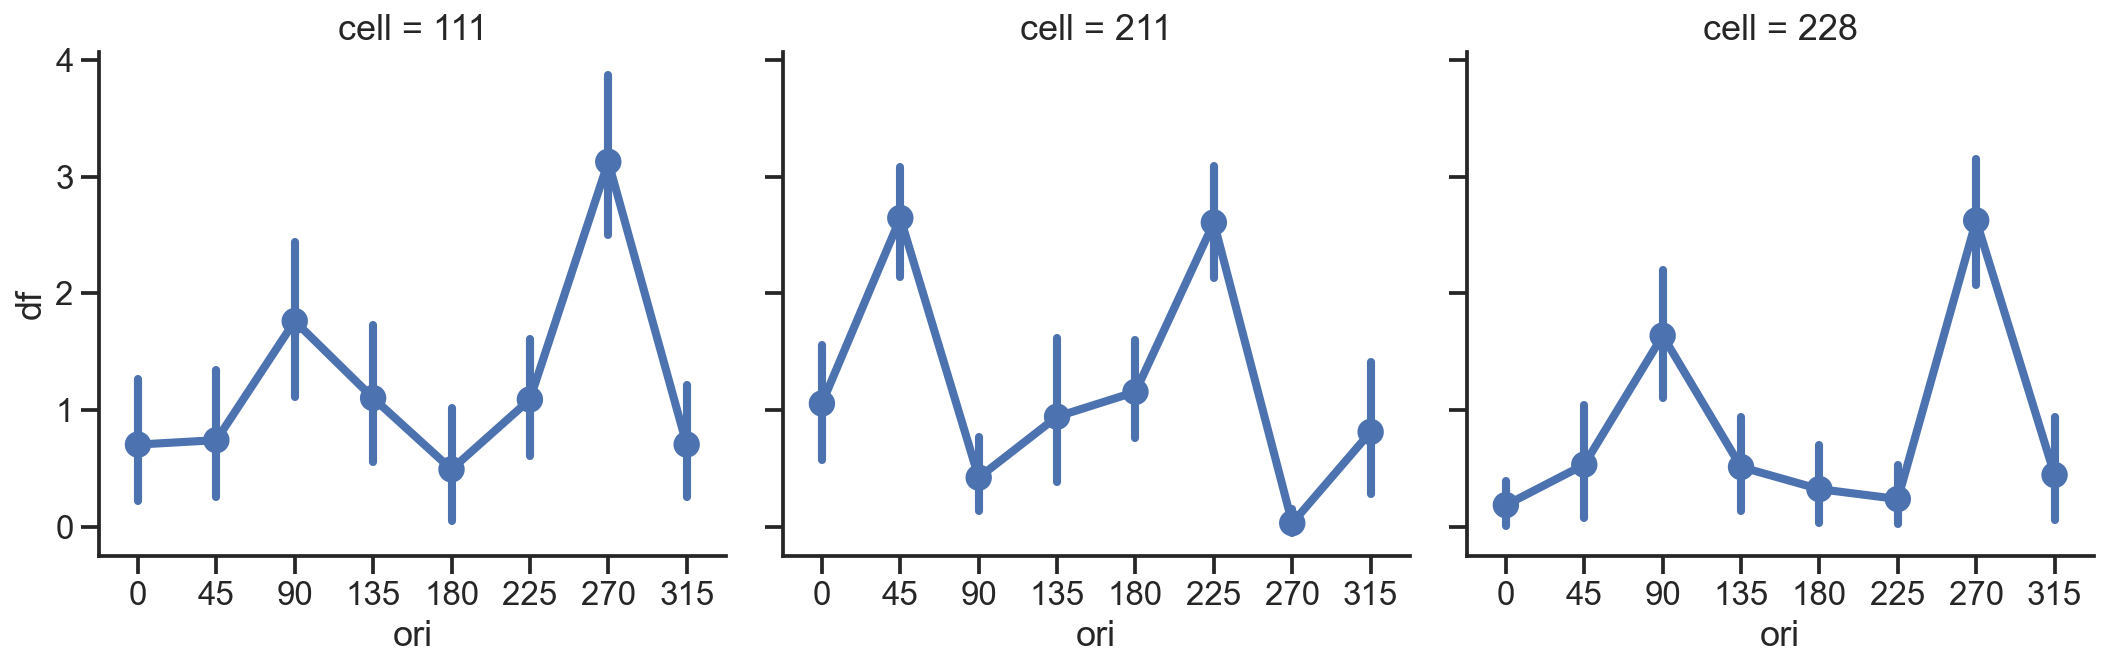

In [328]:
with sns.plotting_context('talk'):
    plot.example_tuning(mdf[mdf.osi > 0.3])
plt.gcf().savefig('ex tunings 2 osi greater than 03')

C:\Users\Will\Anaconda3\envs\caiman-online\lib\site-packages\seaborn\axisgrid.py:382: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


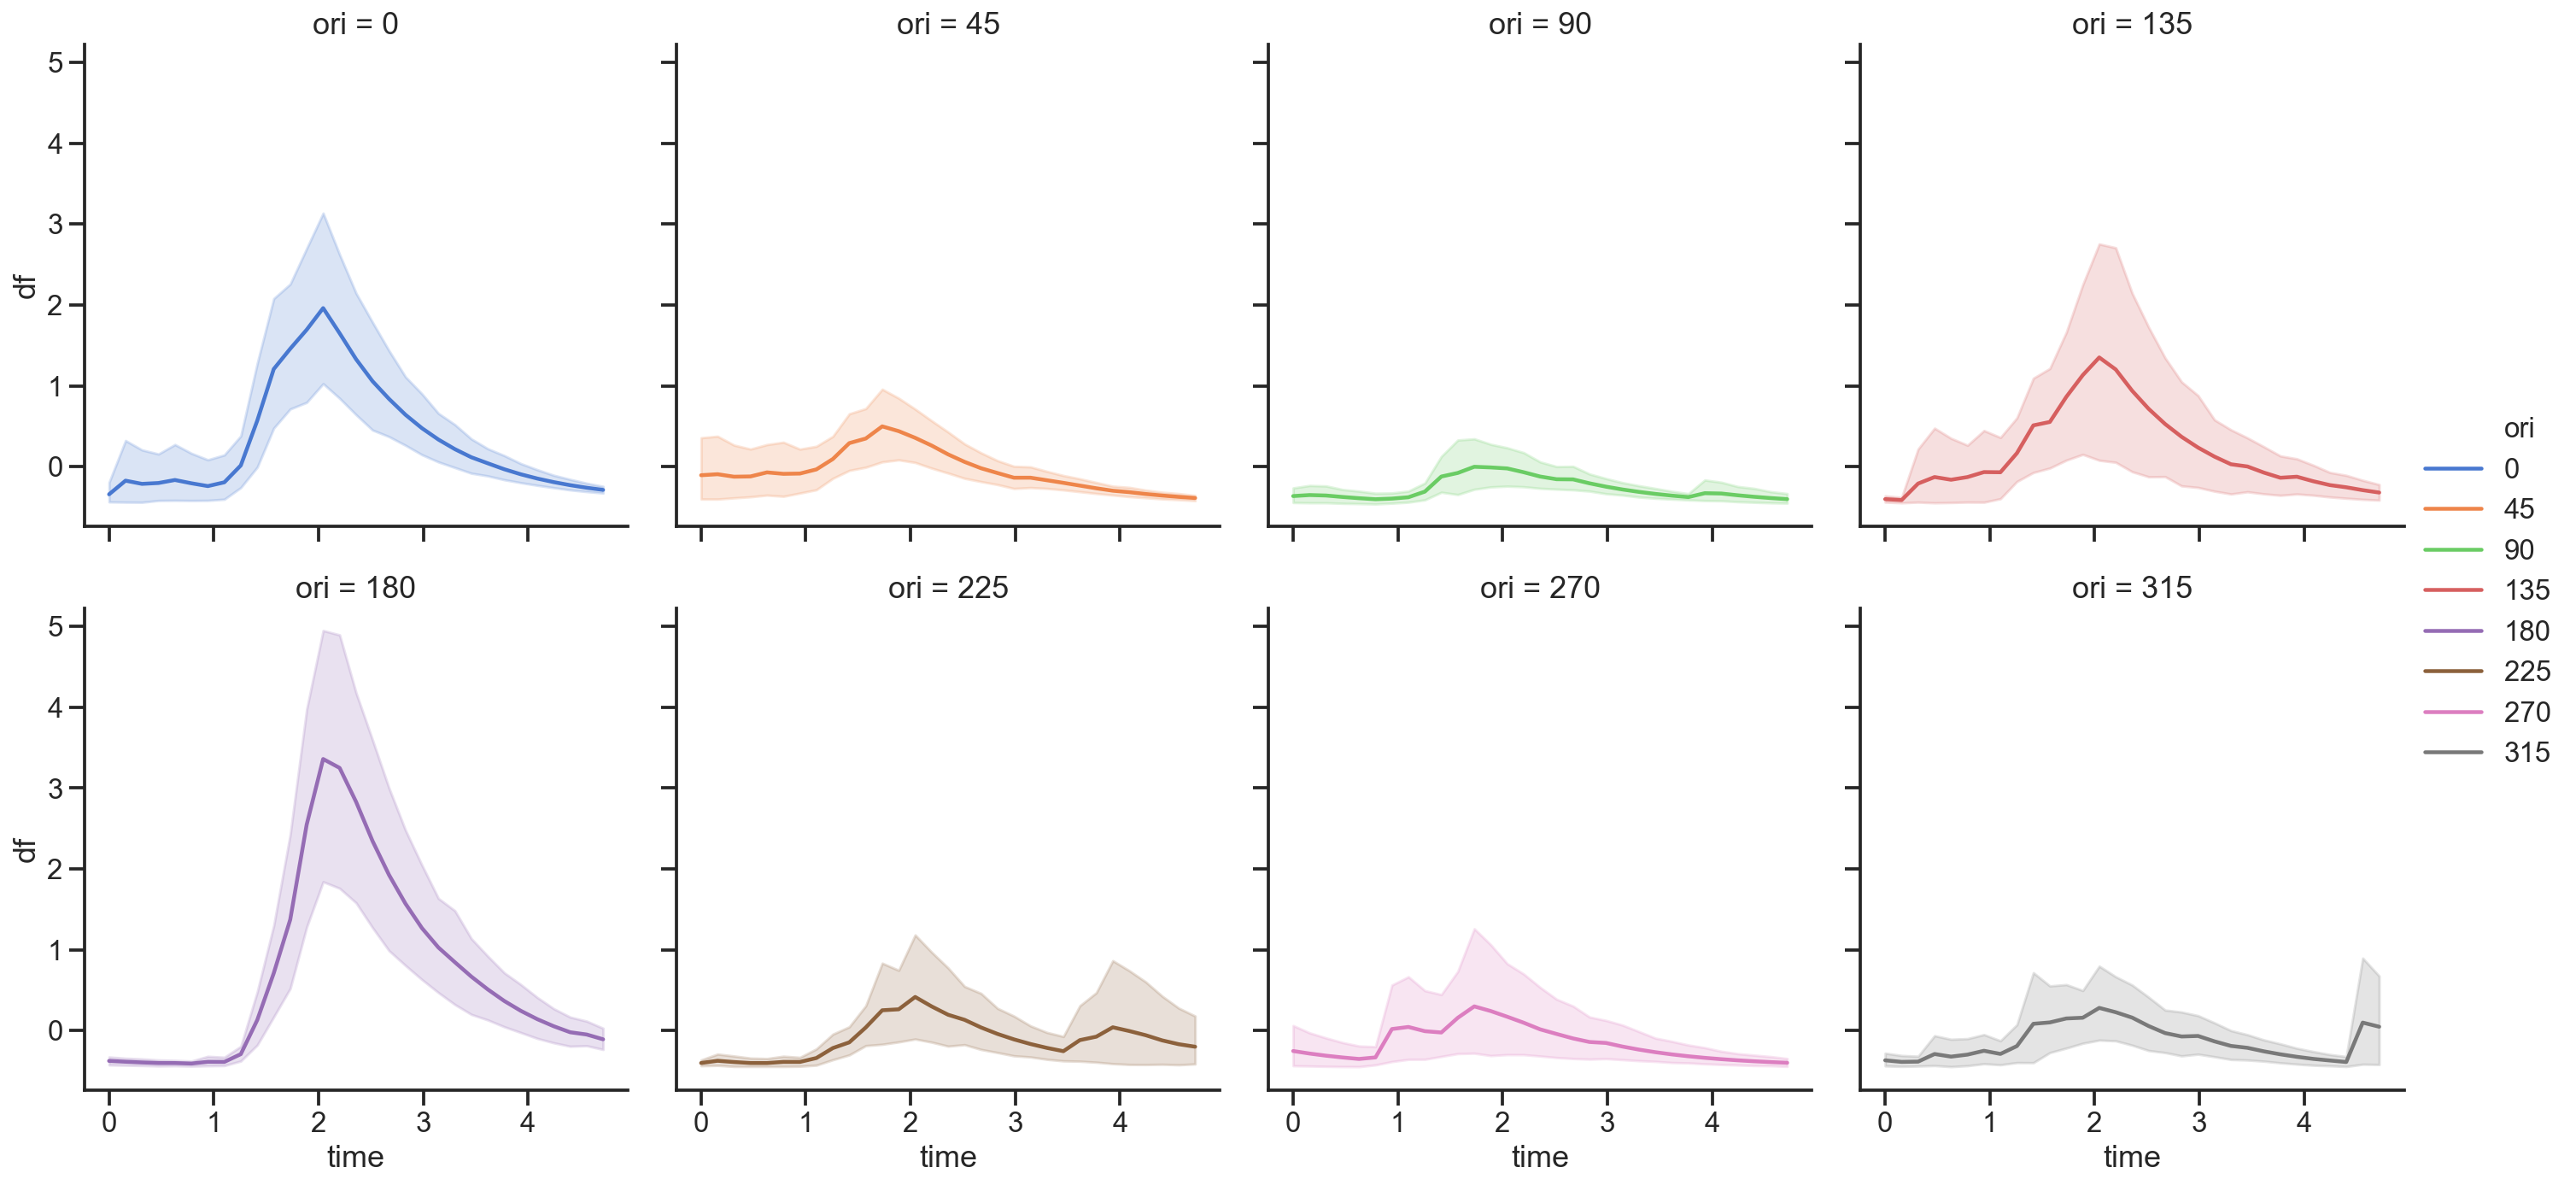

In [329]:
with sns.plotting_context('talk'):
    sns.relplot(x='time', y='df', data=df[(df.cell==26) & (df.ori > -45)], kind='line', col='ori', 
                col_wrap=4, hue='ori', palette=sns.color_palette("muted",8))
    # sns.set(font_scale=4)
    # sns.set_style('ticks',{'axes.spines.right': False, 'axes.spines.top': False}) # removes annoying top and right axis

#     plt.savefig('cell 26 example traces tuning')

C:\Users\Will\Anaconda3\envs\caiman-online\lib\site-packages\seaborn\axisgrid.py:382: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


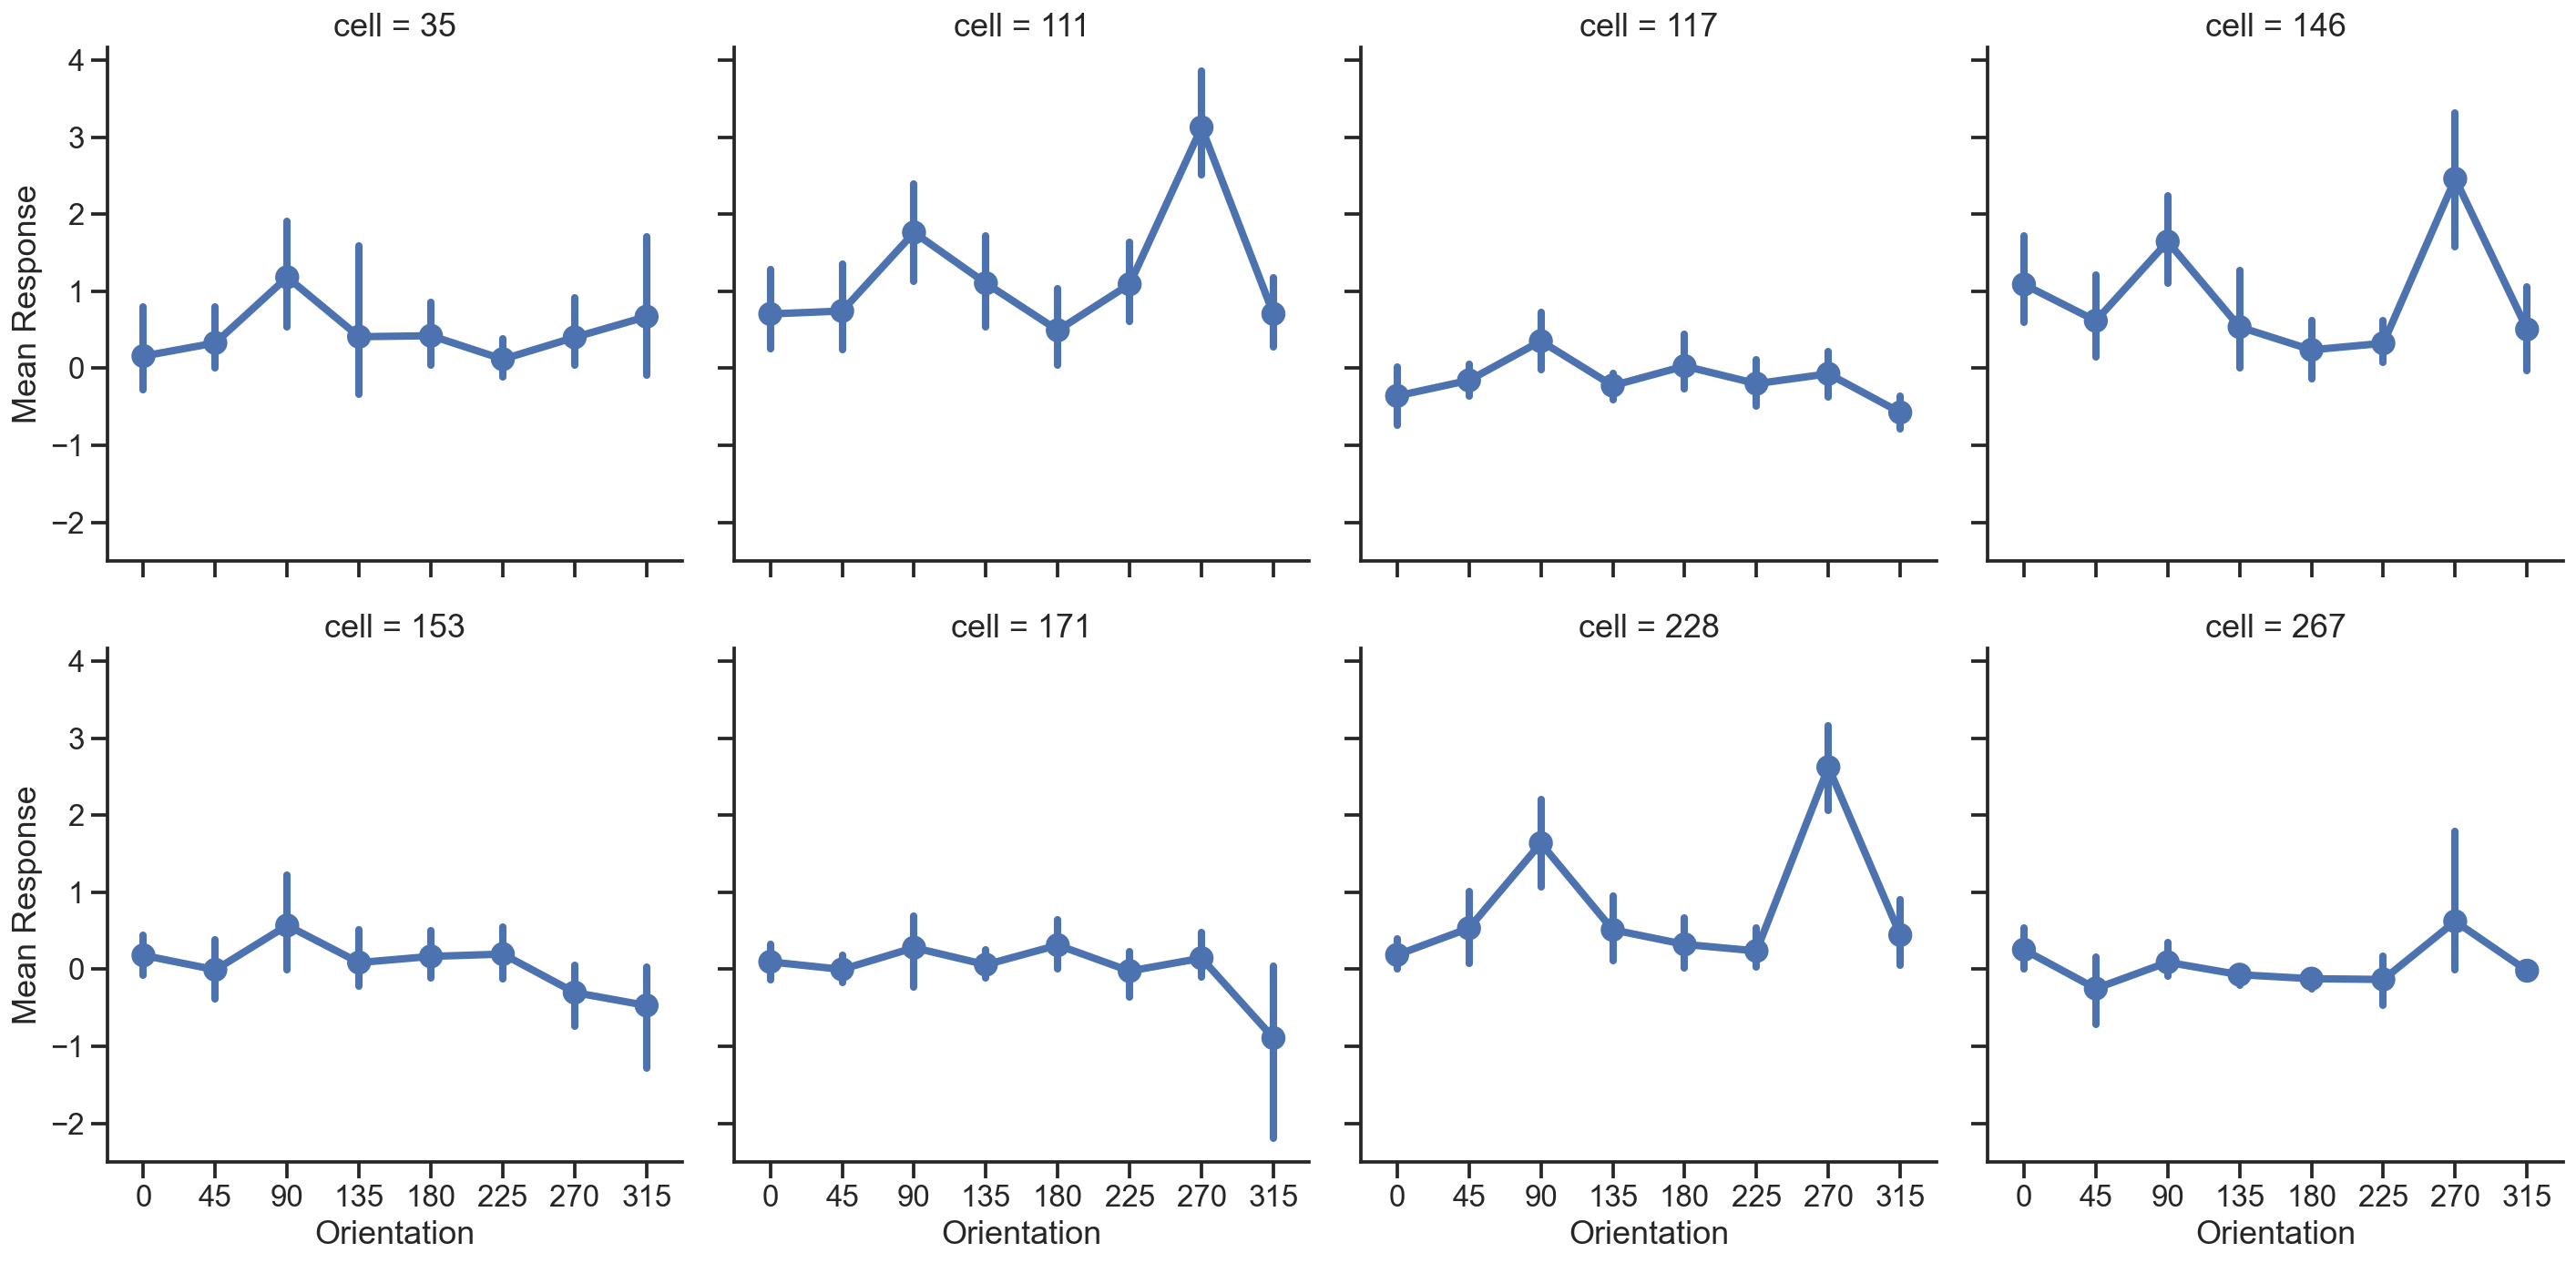

In [412]:
# example chosen ensemble tuning curves
with sns.plotting_context('talk'):
    cells = mdf[(mdf.pref == 90) & (mdf.vis_resp==True)].cell.unique()
    dat = mdf[(mdf.cell.isin(cells)) & (mdf.ori > -45)]
    sns.catplot(x='ori', y='df', data=dat, col='cell', kind='point', col_wrap=4)
    # plt.savefig('ensemble of 180')
    
    f = plt.gcf()
#     axes = f.axes.ravel()
    for a in f.axes[4:]:
        a.set_xlabel('Orientation')

    f.axes[0].set_ylabel('Mean Response')
    f.axes[4].set_ylabel('Mean Response')
    
plt.savefig('ensemble of 90s all osis')

C:\Users\Will\Anaconda3\envs\caiman-online\lib\site-packages\seaborn\axisgrid.py:382: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


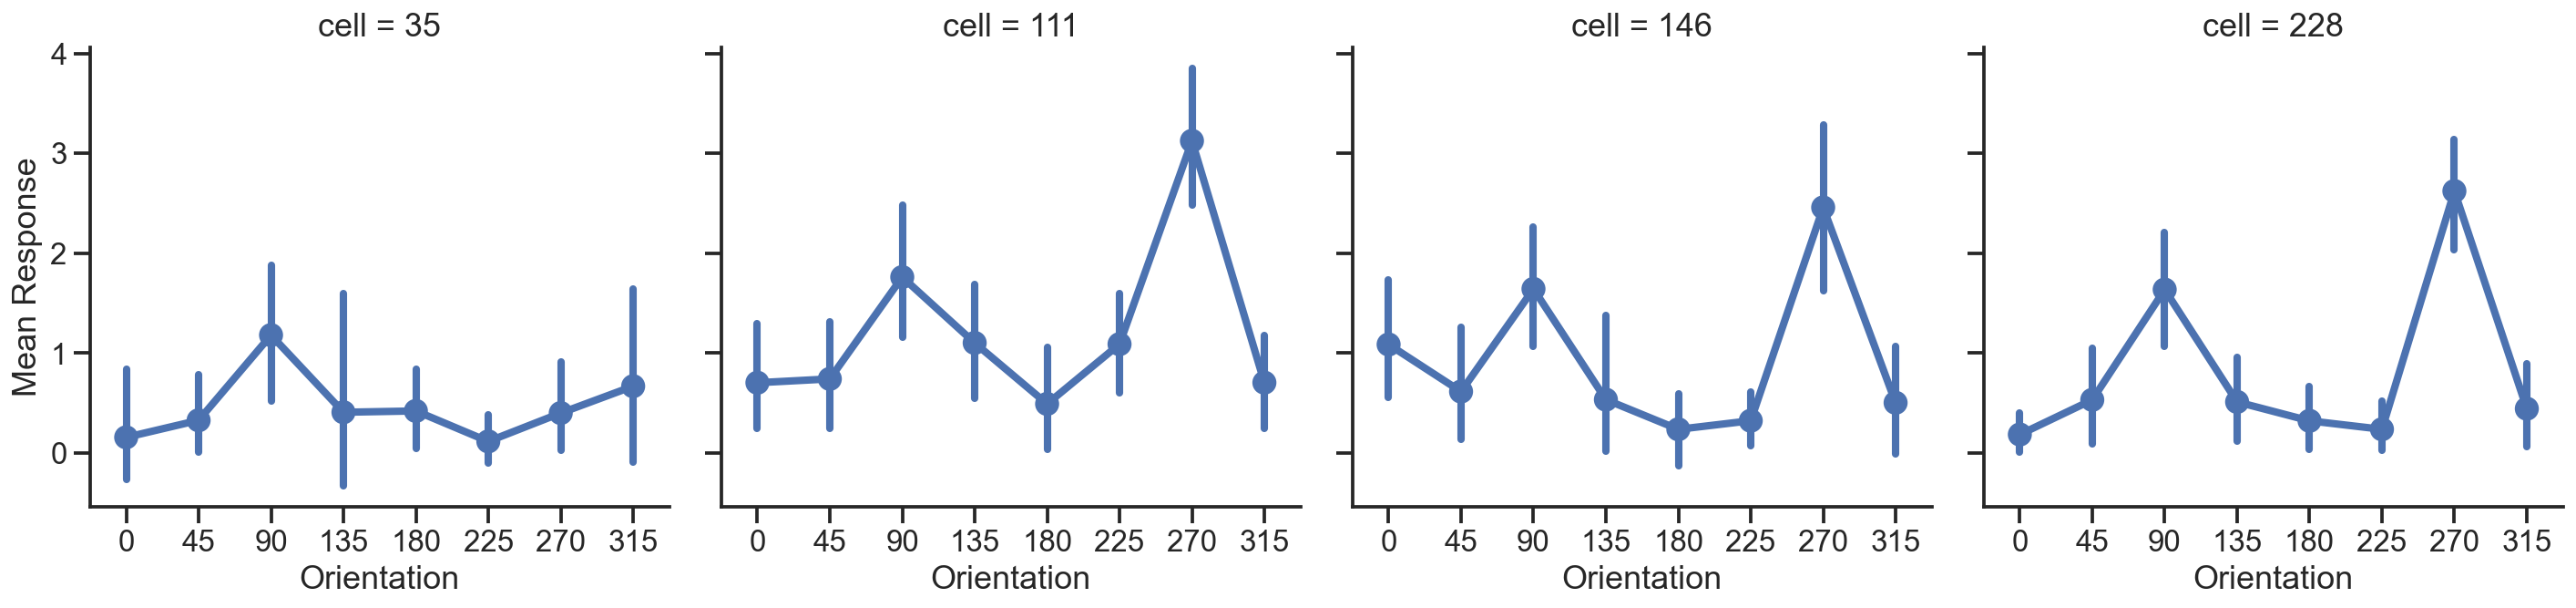

In [408]:
# example chosen ensemble tuning curves
with sns.plotting_context('talk'):
    cells = mdf[(mdf.pref == 90) & (mdf.vis_resp==True) & (mdf.osi > 0.1)].cell.unique()
    dat = mdf[(mdf.cell.isin(cells)) & (mdf.ori > -45)]
    sns.catplot(x='ori', y='df', data=dat, col='cell', kind='point', col_wrap=4)
    
f = plt.gcf()

for a in f.axes:
    a.set_xlabel('Orientation')

f.axes[0].set_ylabel('Mean Response')
plt.savefig('ensemble of 90s 01 osi or better')

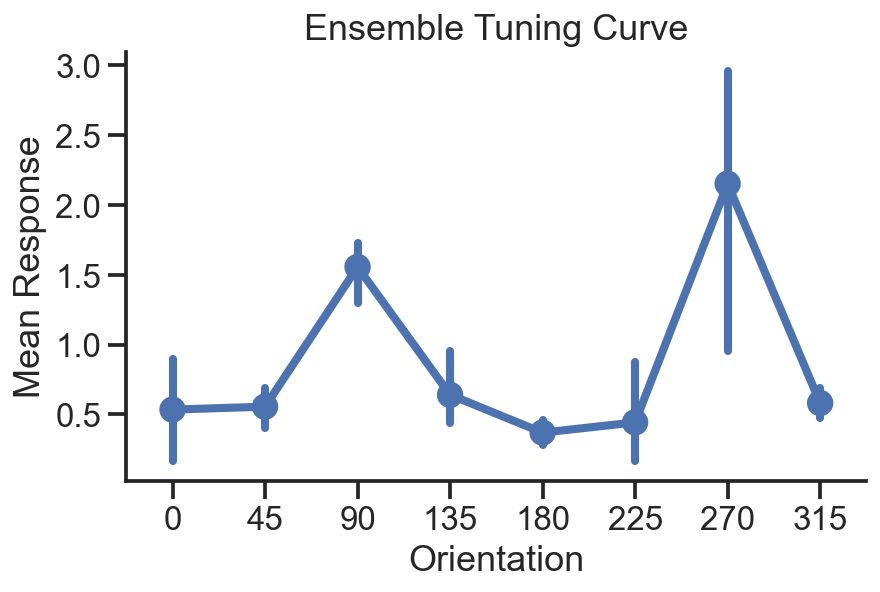

In [402]:
# make mean osi for ensemble
cells = mdf[(mdf.pref == 90) & (mdf.vis_resp==True) & (mdf.osi > 0.1)].cell.unique()
dat = mdf[(mdf.cell.isin(cells)) & (mdf.ori > -45)]
mdat = dat.groupby(['cell', 'ori']).mean().reset_index()
# mdat = dat.groupby(['cell', 'ori']).mean().groupby(['ori']).mean().reset_index()
# sdat = dat.groupby(['cell', 'ori']).mean().groupby(['ori']).sem().reset_index()
# plt.errorbar(mdat.ori.unique(), mdat.df, sdat.df, fmt='-o', lw=3)
with sns.plotting_context('talk'):
    sns.pointplot(x='ori', y='df', data=mdat)
    ax = plt.gca()
    ax.set_title('Ensemble Tuning Curve')
    ax.set_ylabel('Mean Response')
    ax.set_xlabel('Orientation')
    
plt.savefig('ensemble TC for 90 and 270')

c:\users\will\lab code\caiman_online\caiman_online\plot.py:87: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(data.ori180.unique())
c:\users\will\lab code\caiman_online\caiman_online\plot.py:94: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(data.ori.unique())


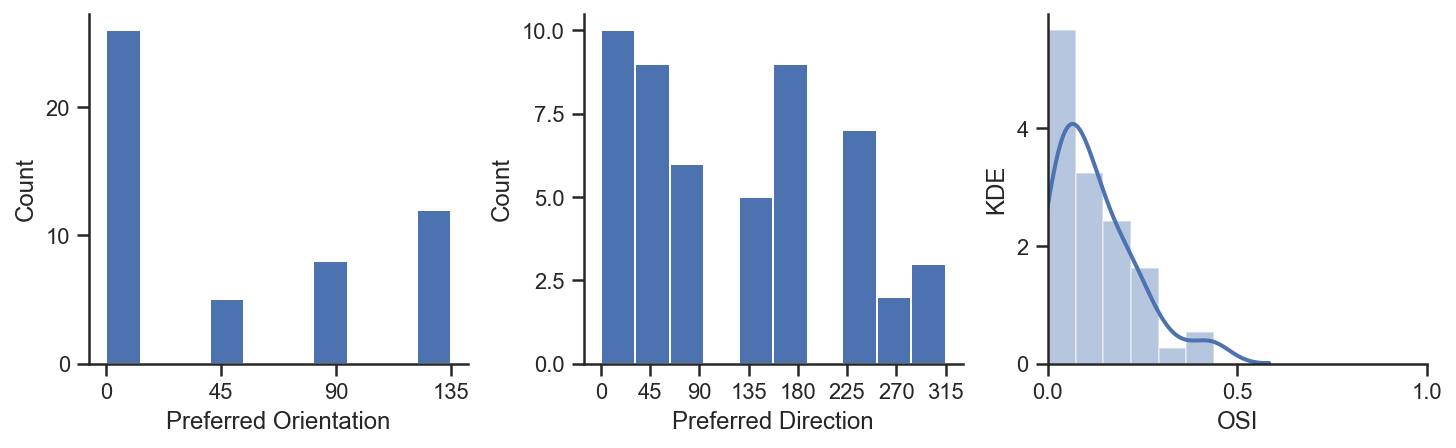

In [348]:
mdf = mdf[(mdf.vis_resp==True)]

with sns.plotting_context('notebook'):
    plot.plot_ori_dists(mdf)

# plt.gcf().savefig('ori dists 51 cells of 298 aka 17 percent')

In [234]:
# do the same but for the daq
plt.imshow(vpsths[20,:,:].transpose((2,0,1)), aspect='auto')

ValueError: cannot reshape array of size 4470 into shape (2,0,1)

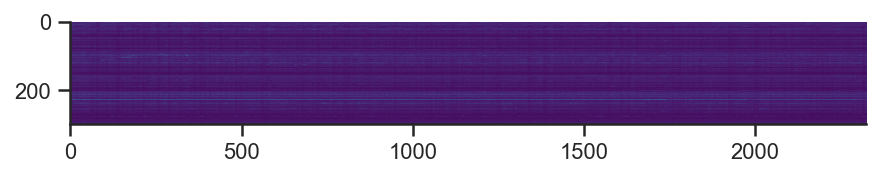

In [123]:
orig_shape = vpsths.shape
vpsths_flat = vpsths.transpose((1,0,2)).reshape((vpsths.shape[1],-1))
plt.imshow(vpsths_flat)

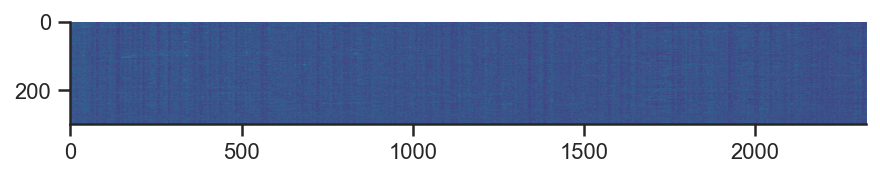

In [127]:
data = vpsths_flat - vpsths_flat.min(axis=1).reshape(-1,1)
data = sklearn.preprocessing.scale(vpsths_flat, axis=1)
plt.imshow(data)

In [222]:
data2 = np.array(np.split(data, 155, axis=1))
data2.T.shape

(15, 298, 155)

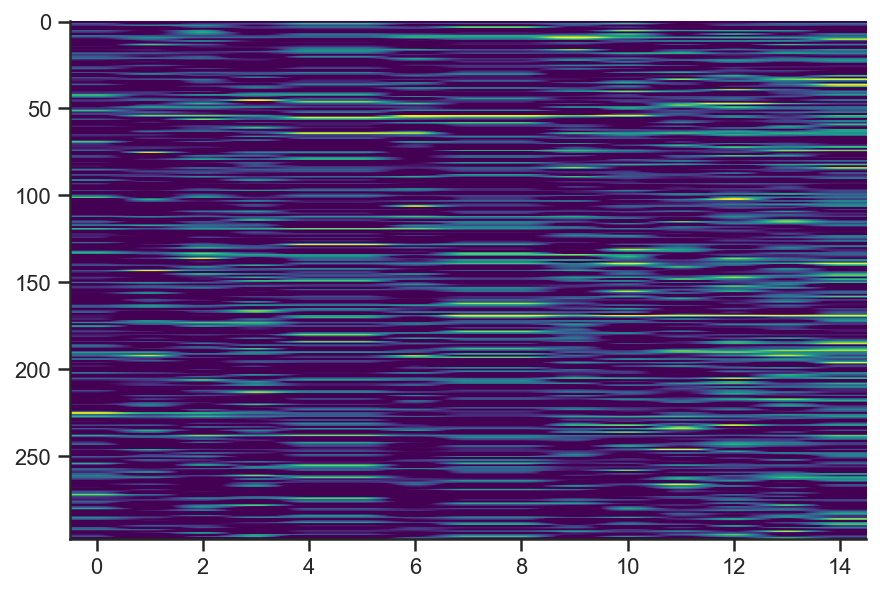

In [221]:
plt.imshow(data2[1,:,:], aspect='auto', vmin=0, vmax=3)

Text(0.5, 0.98, 'First 5 Trials')

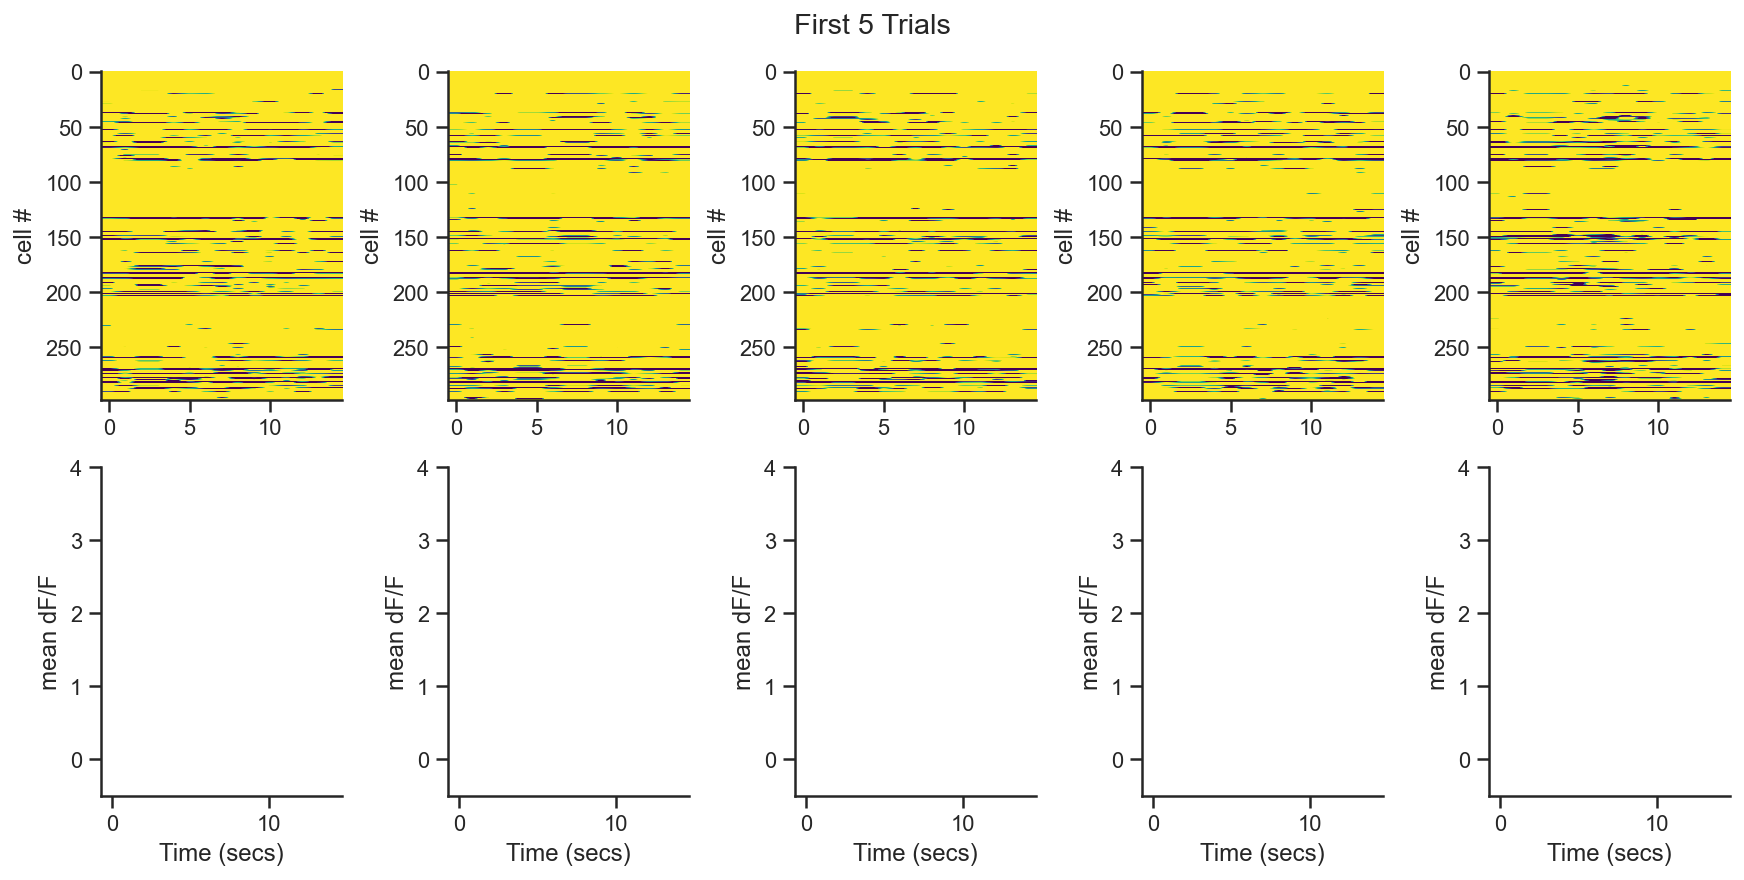

In [111]:
# real time, not frames
length_seconds = int(vpsths.shape[2]/6.36)
times = np.round(np.linspace(0,length_seconds, 6),1)

ncol=5
f, axes = plt.subplots(2,ncol, figsize=(12,6))
axes = axes.ravel()

for i,ax in enumerate(axes[0:5]):
    ax.set_ylabel('cell #')
    ax.imshow(vpsths[i,:,:], aspect='auto', vmin=-.5, vmax=4)
#     ax.set_xticks(np.arange(0,vpsths.shape[2],2))
#     ax.set_xticklabels(times)
    #f.colorbar()

for i,ax in enumerate(axes[5:11]):
#     ax.plot(np.mean(traces[i,:,:],axis =0))
    plot.mean_traces_ci(vpsths[i,:,:], ax=ax)
    ax.set_ylim(-0.5,4)
    ax.set_ylabel('mean dF/F')
    ax.set_xlabel('Time (secs)')
#     ax.set_xticks(np.arange(0,vpsths.shape[2],6))
#     ax.set_xticklabels(times)
    
plt.suptitle('First 5 Trials')